In [1]:
%pip install flyr

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Python39\python.exe -m pip install --upgrade pip' command.


#### 1. Original image show

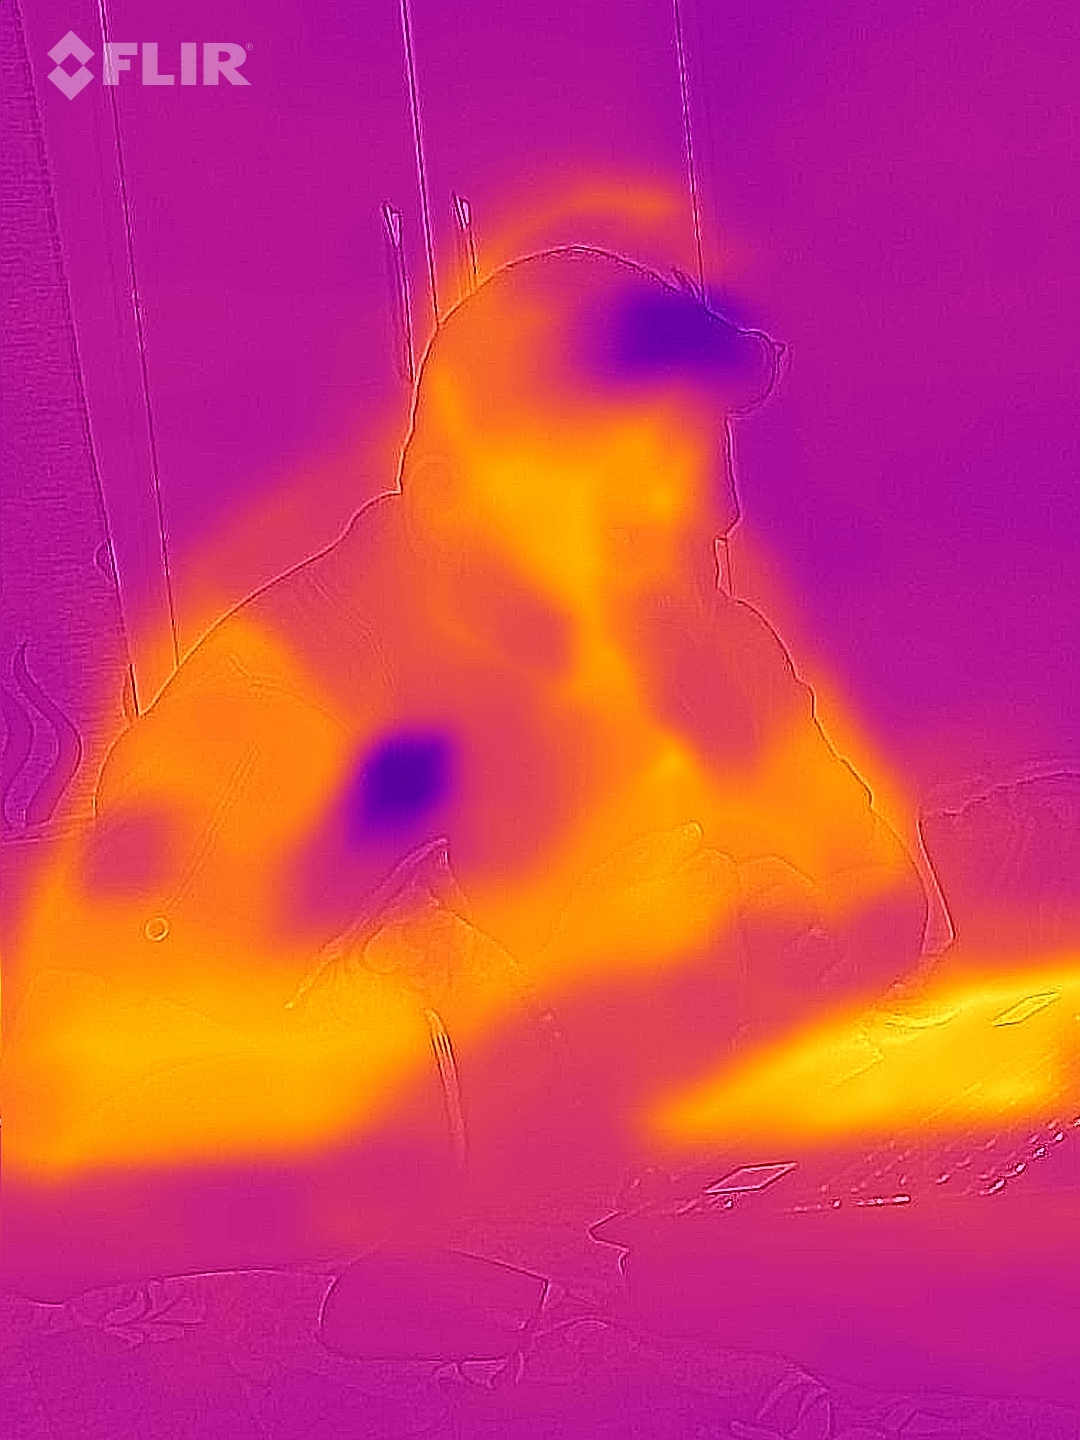

In [2]:
# Dataset source: https://www.kaggle.com/datasets/drshrivishaltripathi/thermal-image-of-faces-for-temperature-detection
# original image
import flyr
from IPython.display import Image, display

root_path=r'../数据库/Thermal Image of Faces for Temperature Detection/1-20220708T112636Z-001/1'
flir_path = root_path + "/FLIR_20220322_073931.jpg"

display(Image(filename=flir_path,width='15%'))


#### 2. Extract temperature information

In [3]:
# extract temperature information

thermogram = flyr.unpack(flir_path)
# thermal = thermogram.kelvin  # As kelvin
thermal = thermogram.celsius  # As celsius
# thermal = thermogram.fahrenheit  # As fahrenheit
# print(thermal)
print(f'width:{len(thermal[0])},height:{len(thermal)}')
f_out=open('results/thermal_image.csv','w',encoding='utf-8')
for m in thermal:
    line=[]
    for l in m:
        line.append(str(l))
    f_out.write(','.join(line)+'\n')
f_out.close()


width:480,height:640


640 480
raw (2184, 1584, 3) 1.378787878787879


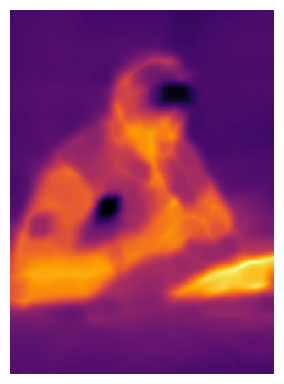

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
sns.set(font='SimHei', font_scale=0.8, style="ticks")  # 解决Seaborn中文显示问题

# show heatmap of temperature information 
def read_infrared_data(file):
  lines = open(file, "r", encoding='utf-8')
  data = []
  for line in lines:
    vs = line.strip().split(",")
    row = [float(v) for v in vs]
    data.append(row)
  return data

temp_data=read_infrared_data('results/thermal_image.csv')

sns.set(rc= {"figure.figsize": (3, 4)})

print(len(temp_data),len(temp_data[0]))
ax = sns.heatmap(temp_data,
                  xticklabels=False,  # remove the labels
                  yticklabels=False,
                  cbar=False,
                  cmap='inferno'
                  )



plt.tight_layout()

# plt.show()

plt.savefig('results/thermal_image_heatmap.jpg', dpi=600, bbox_inches='tight', pad_inches=0)

import imageio.v3 as iio
im = iio.imread('results/thermal_image_heatmap.jpg')
# im.resize(1280,960)

print('raw',im.shape,im.shape[0]/im.shape[1])  


#### 3. Obtain optical image

In [5]:
thermogram = flyr.unpack(flir_path)
optical_arr = thermogram.optical  # Also works
thermogram.optical_pil.save("results/thermal_optical.jpg")

#### 4. Render image with different color sets

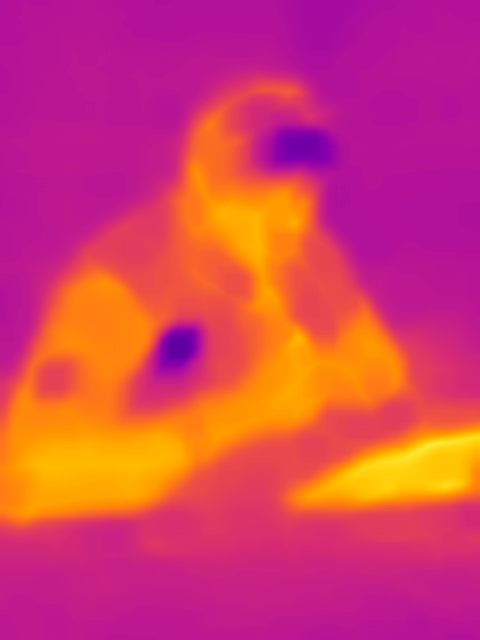

In [6]:

thermogram = flyr.unpack(flir_path)
# render = thermogram.render()  # Use to get raw RGB array
render = thermogram.render_pil()  # Returns Pillow Image object
display(render)
render.save(f"results/render-embedded.png")

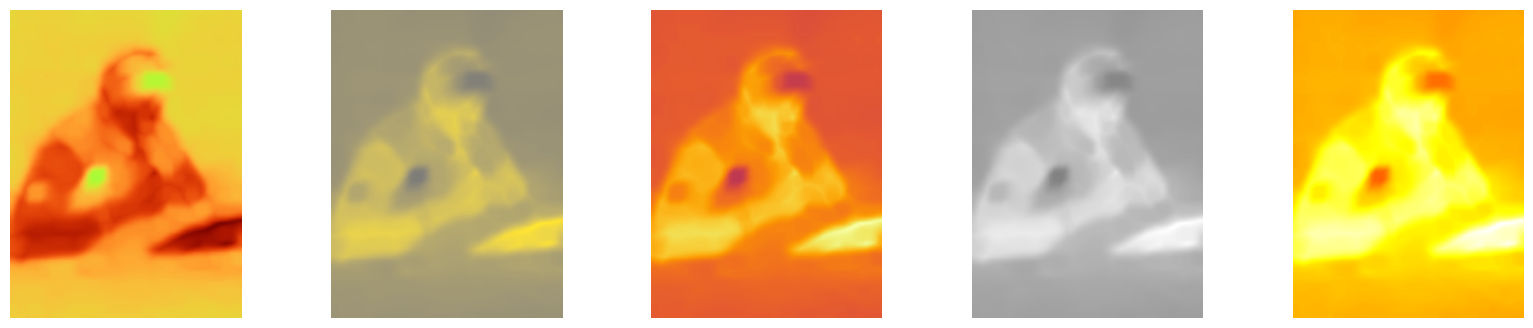

In [7]:
palettes = ["turbo", "cividis", "inferno", "grayscale", "hot"]
renders=[]
for p in palettes:
    # The below call returns a Pillow Image object.
    # A sibling method called `render` returns a numpy array.
    render = thermogram.render_pil(
        min_v=27.1,
        max_v=35.6,
        unit="celsius",
        palette=p,
    )
    renders.append(render)
    render.save(f"results/render-{p}.png")

# diplay
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for render, ax in zip(renders, axes.ravel()):
    ax.grid(False)
    ax.axis('off')
    ax.imshow(render)


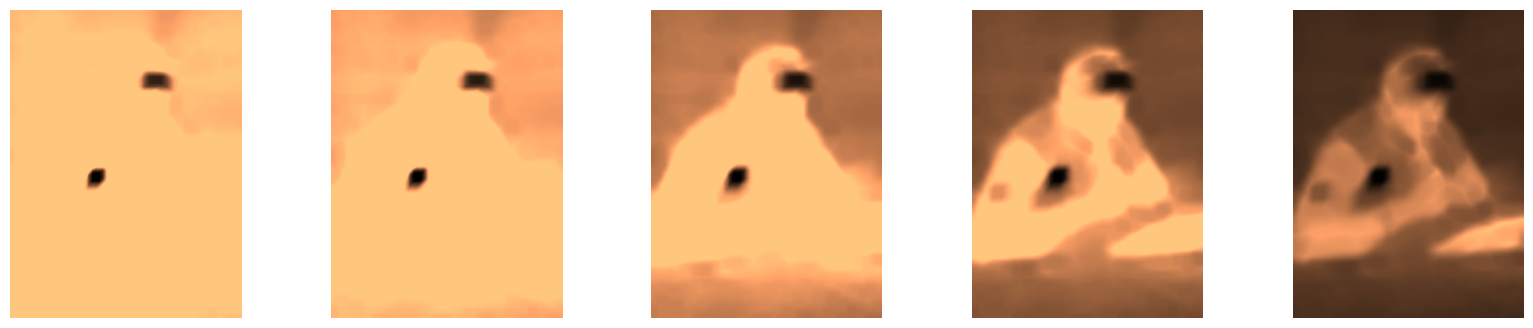

In [15]:
# To render by percentiles, call as below. 
# This approach is useful when it isn't known what temperature range to render.
renders=[]
for i in range(1,5+1):
    render=thermogram.render_pil(
        min_v=0.0,
        max_v=0.2 * i,
        unit="percentiles",
        palette="copper",
    )
    renders.append(render)

# diplay
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for render, ax in zip(renders, axes.ravel()):
    ax.grid(False)
    ax.axis('off')
    ax.imshow(render)

#### 5. Render according to temperature range with mask

In [9]:
mask = thermogram.kelvin > thermogram.kelvin.mean()
thermogram.render_pil(mask=mask).save("results/render-masked.png")

#### 6. Edge detection

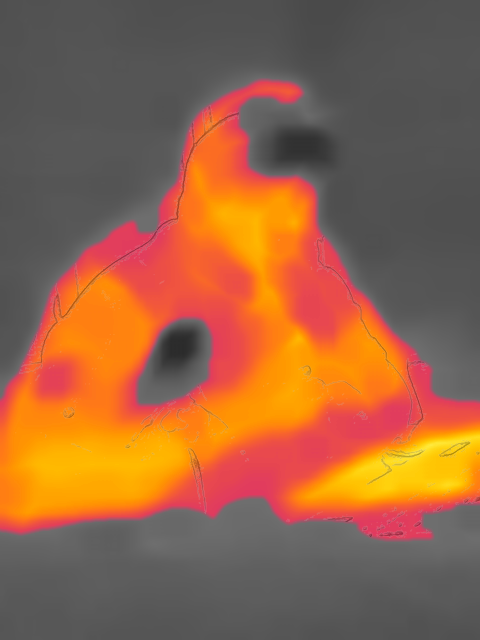

In [10]:
import flyr

thermogram = flyr.unpack(flir_path)
thermogram.render_pil(edge_emphasis=0.0).save("results/render-no-edge-emphasis.png")
thermogram.render_pil(edge_emphasis=0.275).save("results/render-edge-emphasis.png")

mask = thermogram.kelvin > thermogram.kelvin.mean()
render=thermogram.render_pil(edge_emphasis=0.275, mask=mask)
display(render)

#### 7. Picture in Picture

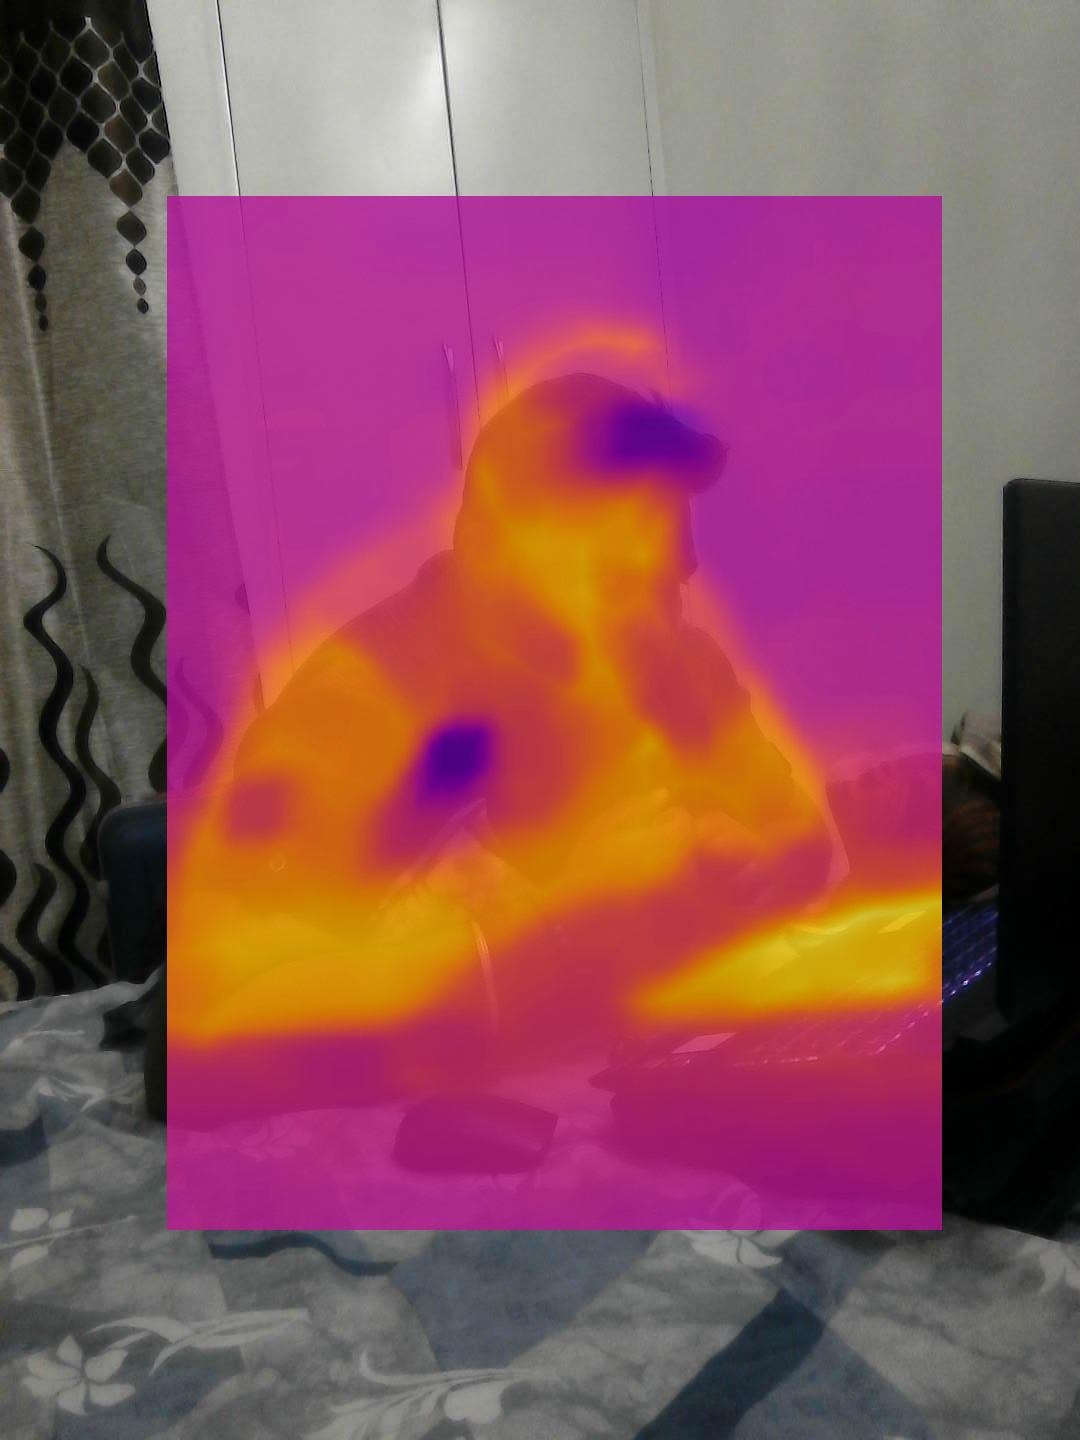

In [11]:
import flyr

thermogram = flyr.unpack(flir_path)
render = thermogram.picture_in_picture_pil(render_opacity=0.8)
display(render)


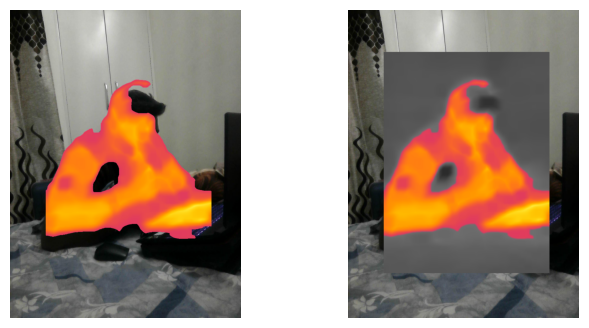

In [12]:
# picture in picture with maske

thermogram = flyr.unpack(flir_path)
mask = thermogram.kelvin > thermogram.kelvin.mean()
render1=thermogram.picture_in_picture_pil(mask=mask, mask_mode="classical")
render1.save("results/pip_classical.png")
render2=thermogram.picture_in_picture_pil(mask=mask, mask_mode="alternative")
render2.save("results/pip_alternative.png")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for render, ax in zip([render1,render2], axes.ravel()):
    ax.grid(False)
    ax.axis('off')
    ax.imshow(render)


#### 8. Adjustable camera settings

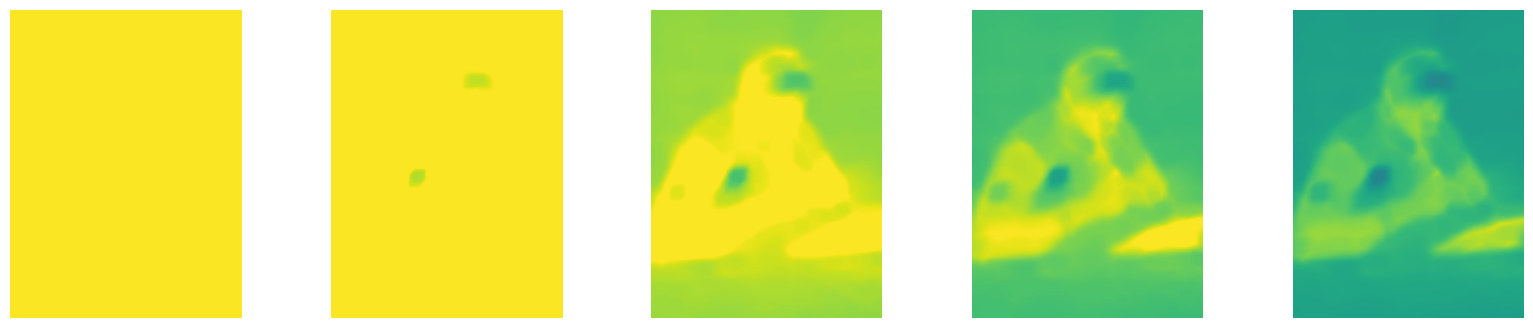

In [13]:
import flyr

thermogram = flyr.unpack(flir_path)

emissivities = [0.6, 0.7, 0.8, 0.9, 1.0]
renders=[]
for e in emissivities:
    thermogram = thermogram.adjust_metadata(emissivity=e)
    # thermal = thermogram.celsius  # Access updated data as normal
    render = thermogram.render_pil(
        min_v=27.1,
        max_v=35.6,
        unit="celsius",
        palette="viridis",
    )
    renders.append(render)
    render.save(f"results/render-{e}.png")
# show
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for render, ax in zip(renders, axes.ravel()):
    ax.grid(False)
    ax.axis('off')
    ax.imshow(render)

#### Get meta data of the image

In [14]:
import flyr

# From file path

thermogram = flyr.unpack(flir_path)
cm = thermogram.camera_metadata
print(cm.data)  # Raw EXIF data (dict)
print(cm.gps_data)  # Raw GPS data (dict)
print(cm.date_time)  # Parsed datetime object of when picture was taken (datetime)
print(cm.gps_altitude)  # (float)
print(cm.gps_image_direction)  # (float)
print(cm.gps_latitude)  # (float)
print(cm.gps_longitude)  # (float)
print(cm.gps_map_datum)  # (str)
print(cm.make)  # (str)
print(cm.model)  # (str)
print(cm.software)  # (str)
print(cm.x_resolution)  # (float)
print(cm.y_resolution)  # (float)

{'resolution_unit': 2, 'exif_offset': 172, 'make': 'FLIR Systems AB', 'model': '', 'software': 'Common_fileformat', 'orientation': 1, 'y_cb_cr_positioning': 1, 'x_resolution': 72.0, 'y_resolution': 72.0}
{}
None
None
None
None
None
None
FLIR Systems AB

Common_fileformat
72.0
72.0
